# 

In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import os
import sys
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
train_path=os.path.join(os.path.dirname(os.getcwd()),'data/train_.csv')
train=pd.read_csv(train_path,header=0,index_col=0)
target=train.pop("Survived")
y=target.values
X=train.values

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator,ClassifierMixin,TransformerMixin,clone
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
import xgboost as xgb

In [4]:
dct=DecisionTreeClassifier()
feature_importances=dct.fit(X,y).feature_importances_

In [5]:
feature_importances

array([0.09058974, 0.30926575, 0.02599171, 0.03144159, 0.02790828,
       0.26118701, 0.21817296, 0.01140373, 0.02403923])

In [6]:
train.head(3)

,Pclass,_Title_,_Sex_,SibSp,Parch,Fare,Age,_HasCabin_,_Embarked_
0,3,0,1,1,0,7.2500,22.0,0,0
1,1,1,0,1,0,71.2833,38.0,1,1
2,3,2,0,0,0,7.9250,26.0,0,0


In [7]:
dct1=DecisionTreeClassifier()
scores=cross_val_score(dct1,X=X,y=y,cv=5)
np.mean(scores)

0.7744623973371038

In [8]:
dct2=DecisionTreeClassifier()
scores=cross_val_score(dct1,X=X[:,[0,1,2,3,4,5,6,8]],y=y,cv=5)
np.mean(scores)

0.7823022448149453

In [9]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# ##tunnelling what we miss to predict and why

In [10]:
train_raw=train.join(target)
clf_=DecisionTreeClassifier(criterion='gini')
kfold=KFold(n_splits=5,shuffle=True,random_state=86)
predictions=np.empty((X.shape[0],),dtype=np.int)
for train_index,test_index in kfold.split(X,y):
    clf_.fit(X[train_index],y[train_index])
    prediction=clf_.predict(X[test_index])
    predictions[test_index]=prediction
miss=np.logical_xor(predictions,target)
female=(train['_Sex_']==0)
male=(train['_Sex_']==1)
miss_female=np.logical_and(female,miss)
miss_male=np.logical_and(male,miss)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [11]:
class StackingModel(BaseEstimator,ClassifierMixin,TransformerMixin):
    def __init__(self,basemodels,metamodel,cv):
        self.basemodels=basemodels
        self.metamodel=metamodel
        self.cv=cv
    def fit(self,X,y):
        self.basemodels_=[list() for model in self.basemodels]
        out_of_fold=np.zeros((X.shape[0],len(self.basemodels)))
        kf=KFold(n_splits=self.cv,shuffle=True,random_state=86)
        for i,model in enumerate(self.basemodels):
            for train_index,test_index in kf.split(X,y):
                clone_=clone(model)
                clone_.fit(X[train_index],y[train_index])
                out=clone_.predict(X[test_index])
                out_of_fold[test_index,i]=out
                self.basemodels_[i].append(clone_)
        self.metamodel_=clone(self.metamodel)
        self.metamodel_.fit(out_of_fold,y)
        return self
    def __vote(self,votes_list):
        l=[]
        for votes in votes_list:
            v_=map(lambda x:1 if x>0 else -1,votes)
            vote=0
            for i in v_:
                vote+=i
            if(vote>0):
                l.append(1)
            else:
                l.append(0)
        return l
    def predict(self,X):
        out_of_fold=np.zeros((X.shape[0],len(self.basemodels)))
        for i,basemodels in enumerate(self.basemodels_):
            prediction=np.zeros((X.shape[0],len(basemodels)))
            for j,model in enumerate(basemodels):
                prediction[:,j]=model.predict(X)
            out_of_fold[:,i]=self.__vote(prediction)
        return self.metamodel_.predict(out_of_fold)   
rf=RandomForestClassifier(100)
bg=GradientBoostingClassifier(n_estimators=100)
xg=xgb.XGBClassifier(n_estimators=100)
tree=DecisionTreeClassifier()
stacking=StackingModel([rf,bg,xg],tree,cv=5)
scores=cross_val_score(estimator=stacking,X=X,y=y,scoring='accuracy',cv=5)

D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

In [12]:
np.mean(scores)

0.8272345038827401

# _Title_  as the most important feature 
the chart below is informative ,title 0 is more likey dead ,and title 1,2 is more likely survived 

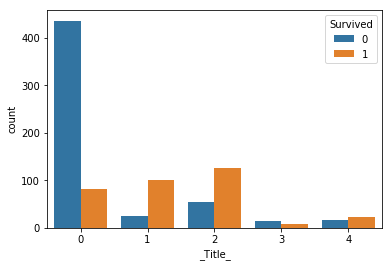

In [13]:
sb.countplot(x='_Title_',hue='Survived',data=train.join(target))

### we are gonna look into title0 and title 1,2 to get more information to apart the dead and the  survived

In [14]:
title0_dead=np.logical_and(train_raw['_Title_']==0,train_raw['Survived']==0)
title0_survived=np.logical_and(train_raw['_Title_']==0,train_raw['Survived']==1)

In [15]:
#assumptions 
#1.as we can see from below ,all  are Pclass 3 or 2 ,
#2.for those high price ticket they were  not single .for those single they got low price ticket
train_raw[title0_dead].sample(50)

,Pclass,_Title_,_Sex_,SibSp,Parch,Fare,Age,_HasCabin_,_Embarked_,Survived
565,3,0,1,2,0,24.1500,24.0,0,0,0
0,3,0,1,1,0,7.2500,22.0,0,0,0
718,3,0,1,0,0,15.5000,63.0,0,2,0
353,3,0,1,1,0,17.8000,25.0,0,0,0
441,3,0,1,0,0,9.5000,20.0,0,0,0
221,2,0,1,0,0,13.0000,27.0,0,0,0
372,3,0,1,0,0,8.0500,19.0,0,0,0
761,3,0,1,0,0,7.1250,41.0,0,0,0
468,3,0,1,0,0,7.7250,25.0,0,2,0
631,3,0,1,0,0,7.0542,51.0,0,0,0


In [16]:
# as we can see from below ,all pclass survived male are single
train_raw[title0_survived].sample(20)

,Pclass,_Title_,_Sex_,SibSp,Parch,Fare,Age,_HasCabin_,_Embarked_,Survived
889,1,0,1,0,0,30.0000,26.0,1,1,1
664,3,0,1,1,0,7.9250,20.0,0,0,1
570,2,0,1,0,0,10.5000,62.0,0,0,1
737,1,0,1,0,0,512.3292,35.0,1,1,1
599,1,0,1,1,0,56.9292,49.0,1,1,1
604,1,0,1,0,0,26.5500,35.0,0,1,1
587,1,0,1,1,1,79.2000,60.0,1,1,1
744,3,0,1,0,0,7.9250,31.0,0,0,1
579,3,0,1,0,0,7.9250,32.0,0,0,1
507,1,0,1,0,0,26.5500,49.0,0,0,1


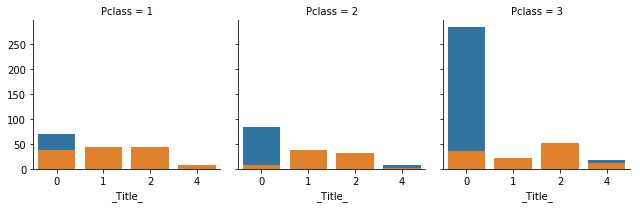

In [17]:
# assumption 1 proved
g=sb.FacetGrid(col='Pclass',hue='Survived',data=train_raw)
g.map(sb.countplot,'_Title_')

In [18]:
train_raw['Family_Size']=train_raw['SibSp']+train_raw['Parch']
train_raw['IsAlone']=0
for index in train_raw['IsAlone'].index:
    if(train_raw.loc[index,'Family_Size']==0):
        train_raw.loc[index,'IsAlone']=1

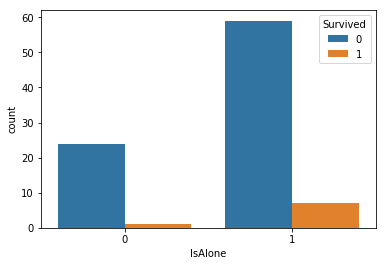

In [19]:
#in pclass 2  title0,we explore the difference between survived and dead 
pclass2_title0=np.logical_and(train['_Title_']==0,train['Pclass']==2)
sb.countplot(x='IsAlone',hue='Survived',data=train_raw[pclass2_title0])

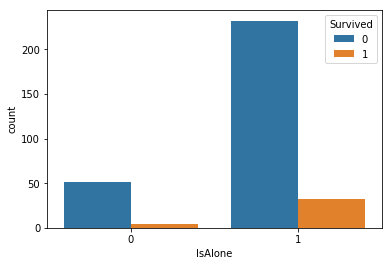

In [20]:
pclass3_title0=np.logical_and(train['_Title_']==0,train['Pclass']==3)
sb.countplot(x='IsAlone',hue='Survived',data=train_raw[pclass3_title0])

#3 assumption 2 should be denied .as we can see from above ,isalone doesnt help predict in title0

# Family_Size exploration

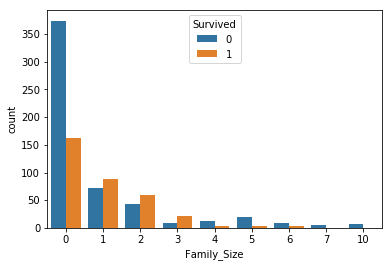

In [21]:
sb.countplot(x='Family_Size',hue='Survived',data=train_raw)

In [22]:
train_raw.head(3)

,Pclass,_Title_,_Sex_,SibSp,Parch,Fare,Age,_HasCabin_,_Embarked_,Survived,Family_Size,IsAlone
0,3,0,1,1,0,7.2500,22.0,0,0,0,1,0
1,1,1,0,1,0,71.2833,38.0,1,1,1,1,0
2,3,2,0,0,0,7.9250,26.0,0,0,1,0,1


In [23]:
y=train_raw.pop('Survived').values
X=train_raw.values
rf=RandomForestClassifier(100)
bg=GradientBoostingClassifier(n_estimators=100)
xg=xgb.XGBClassifier(n_estimators=100)
tree=DecisionTreeClassifier()
stacking=StackingModel([rf,bg,xg],tree,cv=5)
scores=cross_val_score(estimator=stacking,X=X,y=y,scoring='accuracy',cv=5)

D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\software\anaconda\exe\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

In [24]:
np.mean(scores)

0.83169742962855

In [25]:
train_raw['Survived']=y
train_raw['FareBins']=pd.qcut(train["Fare"],4)

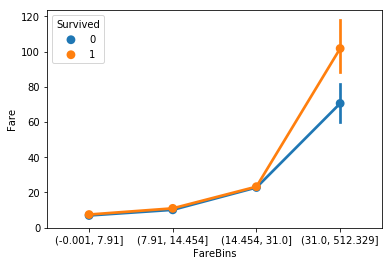

In [26]:
sb.pointplot(x="FareBins",y="Fare",hue="Survived",data=train_raw)

In [27]:
train_raw["AgeBins"]=pd.cut(train_raw["Age"].astype("int"),5)

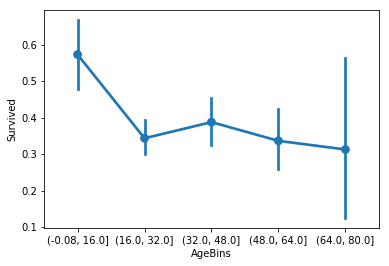

In [28]:
sb.pointplot(x="AgeBins",y="Survived",data=train_raw)

In [29]:
train_raw.head(3)

,Pclass,_Title_,_Sex_,SibSp,Parch,Fare,Age,_HasCabin_,_Embarked_,Family_Size,IsAlone,Survived,FareBins,AgeBins
0,3,0,1,1,0,7.2500,22.0,0,0,1,0,0,"(-0.001, 7.91]","(16.0, 32.0]"
1,1,1,0,1,0,71.2833,38.0,1,1,1,0,1,"(31.0, 512.329]","(32.0, 48.0]"
2,3,2,0,0,0,7.9250,26.0,0,0,0,1,1,"(7.91, 14.454]","(16.0, 32.0]"


In [42]:
from sklearn.preprocessing import LabelEncoder

In [43]:
s=["paris","usa","usa"]
lb=LabelEncoder()
lb.fit(s)
lb.transform(s)

LabelEncoder()

array([0, 1, 1], dtype=int64)